# ROUND 1
use pre-calculated CQT

In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("../../..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [2]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = '../../../data/septimbre/piano_large_short_256',
    mix = 1,
    input = '.cqt.npy',
    output = '.npy'
)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)
# 如果开了benchmark，batchsize最好一样大，且是两个数据集大小的公因数
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)

val = Instruments(
    folder = '../../../data/septimbre/piano_medium_short_256',
    mix = 1,
    input = '.cqt.npy',
    output = '.npy'
)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)

训练集大小:  1800
输入大小:  torch.Size([1, 2, 288, 360])
输出大小:  torch.Size([1, 84, 360])
测试集大小:  180
输入大小:  torch.Size([1, 2, 288, 360])
输出大小:  torch.Size([1, 84, 360])


In [3]:
from basicamt_bn import BasicAMT_BN
model = BasicAMT_BN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.32, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_bn.pth"
loss_path = "basicamt_bn.loss.txt"
min_loss = float('inf')
epoch_now = 0

In [4]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt_bn.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [5]:
epoch_total = 50
stage_save_interval = 45    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.01   # 加入噪声 经过听觉和可视化觉得0.01是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT_BN.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT_BN.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 10/10 [00:00<00:00, 68.40it/s]


====> Epoch: 1 Average train loss: 85056.3116; Average val loss: 32489.5262


100%|██████████| 10/10 [00:00<00:00, 71.53it/s]


====> Epoch: 2 Average train loss: 16217.7760; Average val loss: 14744.9371


100%|██████████| 10/10 [00:00<00:00, 67.51it/s]


====> Epoch: 3 Average train loss: 7456.4130; Average val loss: 9944.7162


100%|██████████| 10/10 [00:00<00:00, 56.46it/s]


====> Epoch: 4 Average train loss: 4703.1020; Average val loss: 8465.9134


100%|██████████| 10/10 [00:00<00:00, 65.46it/s]


====> Epoch: 5 Average train loss: 3454.3282; Average val loss: 9614.1144


100%|██████████| 10/10 [00:00<00:00, 66.32it/s]


====> Epoch: 6 Average train loss: 2765.3529; Average val loss: 10761.6246


100%|██████████| 10/10 [00:00<00:00, 58.05it/s]


====> Epoch: 7 Average train loss: 2354.9651; Average val loss: 7375.5334


100%|██████████| 10/10 [00:00<00:00, 69.41it/s]


====> Epoch: 8 Average train loss: 2063.2258; Average val loss: 7348.4241


100%|██████████| 10/10 [00:00<00:00, 57.33it/s]


====> Epoch: 9 Average train loss: 1858.2492; Average val loss: 7152.3724


100%|██████████| 10/10 [00:00<00:00, 70.36it/s]


====> Epoch: 10 Average train loss: 1699.8477; Average val loss: 7260.7447


100%|██████████| 10/10 [00:00<00:00, 68.62it/s]


====> Epoch: 11 Average train loss: 1580.5959; Average val loss: 6854.1443


 15%|█▌        | 15/100 [00:00<00:03, 21.27it/s]


KeyboardInterrupt: 

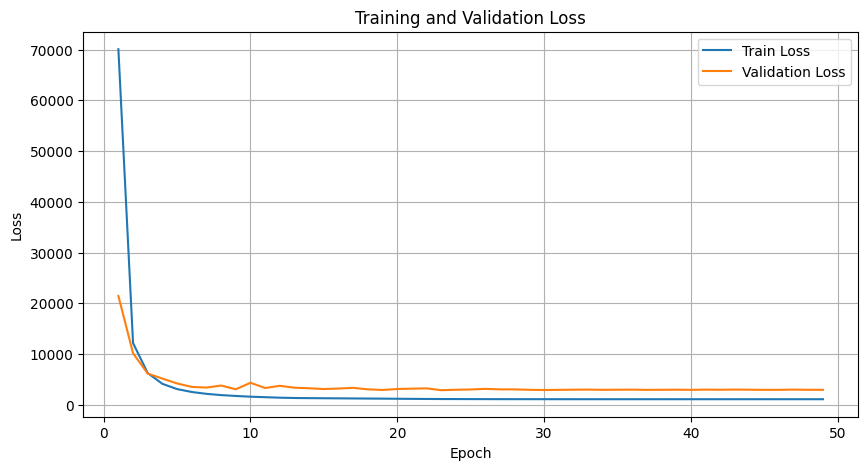

In [ ]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [ ]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_bn.pth'
epoch: 23, loss: 2631.9402248840333, min_loss: 2685.514651123047


In [ ]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

In [ ]:
# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame

from model.CQT import CQTsmall_fir

cqt = CQTsmall_fir(
    config=CONFIG.CQT
).to(device)


In [ ]:
# 读取音频，分析为CQT
import torchaudio
from utils.midiarray import numpy2midi
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

test_wave_path = "../../../data/inferMusic/piano_short.wav"
# test_wave_path = r'C:\amt\data\septimbre\small\inst0\0.wav'
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)
test_cqt_data = cqt(waveform).to(device)
print(test_cqt_data.shape)

Sample rate: 44100
Channels: 2
Sample width: 2
Number of frames: 186112
Duration (s): 4.220226757369614
data num: 372224
torch.Size([1, 2, 186112])
torch.Size([1, 2, 288, 727])


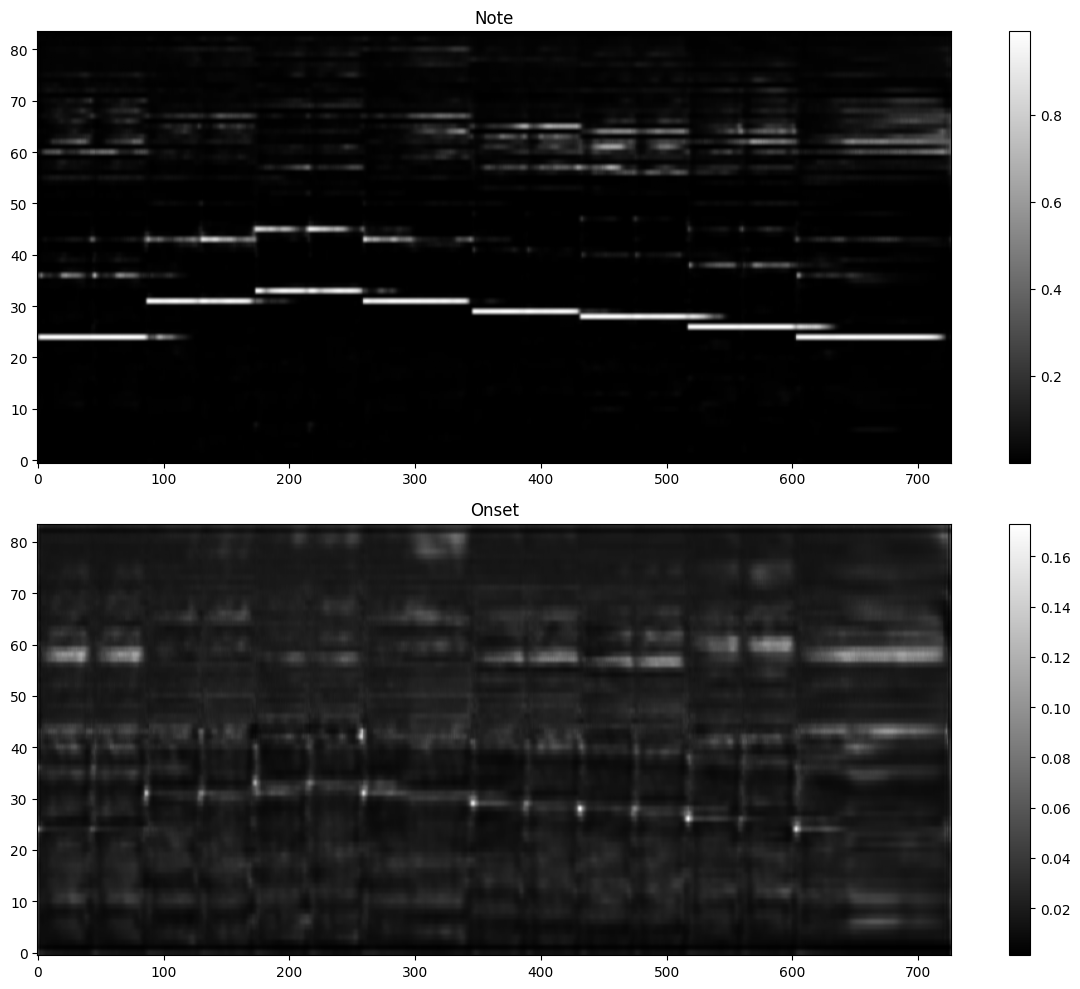

In [ ]:
model.eval()
with torch.no_grad():
    onset, note = model(test_cqt_data)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()